In [ ]:
# | default_exp pgssm
import jax

jax.config.update("jax_enable_x64", True)

# Partially Gaussian State Space Models with linear Signal
> See also the corresponding [section in my thesis](https://stefanheyder.github.io/dissertation/thesis.pdf#nameddest=section.3.3)

In [ ]:
# | code-fold: true
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jrn

A partially gaussian state space model with linear signal is a state space model where the distribution of states $X_t$ is gaussian, but the (conditional) distribution of observations $Y_t$ is non-gaussian, but depends only on signals $S_t = B_tX_t$ for a matrix $B_t$.

That is we consider 

$$
\begin{align*}
    X_0 &\sim \mathcal N(u_{0}, \Sigma_0)\\
    X_{t + 1} &= u_{t + 1} + A_t X_t + \varepsilon_{t + 1}\\
    \varepsilon_{t} &\sim \mathcal N(0, \Sigma_t)\\
    Y_t | X_t &\sim Y_t | S_t \sim p(y_t|s_t).
\end{align*}
$$


::: {.callout-note}
### Implementation Detail
> dependency on parameters

To facilitate faster evaluation we assume that the conditional density of observations $p(y_{t}|s_{t})$ depends on parameters $\xi \in \mathbb R^{(n + 1)\times p \times l}$, i.e. for every observation there are exactly $l$ parameters to consider. The implementation will always assume that we can call 
```python
dist(s, xi)
```
where `dist` is a `tensorflow_probability.distributions.distribution` object that for broadcasting in both $s$ and $\xi$.
:::

## Simulation

As the states are gaussian, we can first simulate the states $X$ and then, conditional on them, calculate $S$ and $\xi$.

In [ ]:
# | export
import jax.numpy as jnp
import jax.random as jrn
from jax import lax, vmap
from jaxtyping import Array, Float, PRNGKeyArray
from tensorflow_probability.substrates.jax.distributions import (
    NegativeBinomial as NBinom,
)
from tensorflow_probability.substrates.jax.distributions import Poisson

from isssm.glssm import log_probs_x, simulate_states
from isssm.typing import PGSSM, GLSSMObservationModel, GLSSMState
from isssm.util import mm_time, mm_time_sim

In [ ]:
# | export
def simulate_pgssm(
    pgssm: PGSSM,
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
) -> tuple[
    Float[Array, "N n+1 m"], Float[Array, "N n+1 p"]
]:  # simulated states and observations
    u, A, D, Sigma0, Sigma, v, B, dist, xi = pgssm
    key, subkey = jrn.split(key)
    X = simulate_states(GLSSMState(u, A, D, Sigma0, Sigma), N, subkey)
    S = v + mm_time_sim(B, X)

    key, subkey = jrn.split(key)
    Y = dist(S, xi).sample(seed=subkey)

    return X, Y

## Running example: Negative Binomial model

As an example consider a variant of the [multivariate AR(1) process model](models/00_gaussian_models.ipynb) with [a seasonal component](models/10_stsm.ipynb) where observations now follow a conditional negative binomial distribution, i.e. $$Y^i_t| X_{t} \sim \text{NegBinom}(\exp((BX_t)^{i}), r),$$ independent for $i = 1, 2$. 

The states $X_t$ consist of two components: 

- a trend- and velocity component as in a [structural time series model](models/10_stsm.ipynb), and
- a seasonal component. 

For the velocity component, we will model a stationary distribution with a small stationary variance.
Stationarity allows us to ensure that sampling from the model will, usually, not lead to numerical issues. Due to the log-link for negative binomial observations we want states to stay within, say, $(-2, 2)$ most of the time, otherwise, we will see many $0$ observations (below -2), or may have problems sampling when $\mathbf E (Y^{i}_{t} | X_{t}) = \exp (BX_{t}^{i})$ becomes large. 

This model has the advantage that we can check whether our implementation can handle multiple issues:

- the states have degenerate distribution (due to the seasonal component),
- the observations are multivariate,
- the observations are integer-valued and
- the observations are non-Gaussian.

We set some sensible defaults and will reuse this model throughout this documentation.

In [ ]:
# | export

from isssm.models.stsm import stsm
from isssm.models.pgssm import nb_pgssm
import jax.scipy.linalg as jsla


def nb_pgssm_running_example(
    x0_trend: Float[Array, "m"] = jnp.zeros(2),
    r: Float = 20.0,
    s2_trend: Float = 0.01,
    s2_speed: Float = 0.1,
    alpha: Float = 0.1,
    omega2: Float = 0.01,
    n: int = 100,
    x0_seasonal: Float[Array, "s"] = jnp.zeros(4),
    s2_seasonal: Float = 0.1,
    Sigma0_seasonal: Float[Array, "s s"] = 0.1 * jnp.eye(4),
    s_order: int = 5,
) -> PGSSM:  # the running example for this package
    """a structural time series model with NBinom observations"""
    Sigma0 = jsla.block_diag(0.01 * jnp.eye(2), Sigma0_seasonal)
    x0 = jnp.concatenate((x0_trend, x0_seasonal))

    model = nb_pgssm(
        stsm(
            x0,
            s2_trend,
            s2_speed,
            s2_seasonal,
            n,
            Sigma0,
            omega2,
            s_order,
            alpha,
        ),
        r,
    )
    return model

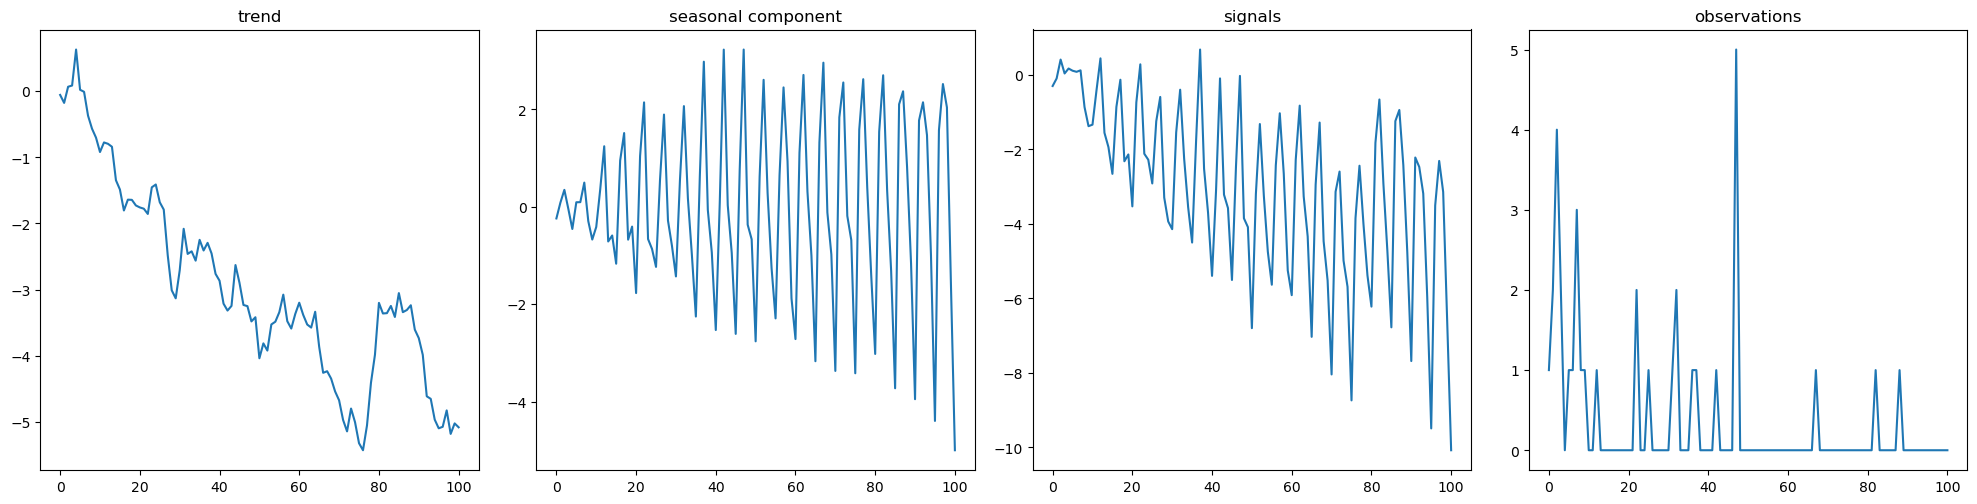

In [ ]:
key = jrn.PRNGKey(518)
model = nb_pgssm_running_example()
N = 1
key, subkey = jrn.split(key)
(X,), (Y,) = simulate_pgssm(model, N, subkey)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
fig.tight_layout()

ax1.set_title("trend")
ax2.set_title("seasonal component")
ax3.set_title("signals")
ax4.set_title("observations")

ax1.plot(X[:, 0])
ax2.plot(X[:, 2])
ax3.plot(vmap(jnp.matmul, (0, 0))(model.B, X))
ax4.plot(Y)

plt.show()

Notice that the observations are now integer valued.

## joint density

To evaluate the joint density we use the same approach as described in [00_glssm#Joint Density], replacing the observation density with the PGSSM one.

In [ ]:
# | export
from isssm.typing import to_states


def log_probs_y(
    x: Float[Array, "n+1 m"],  # states
    y: Float[Array, "n+1 p"],  # observations
    v: Float[Array, "n+1 p"],  # signal biases
    B: Float[Array, "n+1 p m"],  # signal matrices
    dist,  # observation distribution
    xi,  # observation parameters
):
    s = v + (B @ x[:, :, None])[:, :, 0]
    return dist(s, xi).log_prob(y).sum(axis=1)


def log_prob(
    x: Float[Array, "n+1 m"],  # states
    y: Float[Array, "n+1 p"],  # observations
    model: PGSSM,
):
    u, A, D, Sigma0, Sigma, v, B, dist, xi = model
    px = log_probs_x(x, to_states(model)).sum()
    py = log_probs_y(x, y, v, B, dist, xi).sum()
    return px + py

In [ ]:
log_prob(X, Y, model)

Array(-17.57867495, dtype=float64)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()